In [0]:
!pip install -q keras

In [2]:
!python3 drive/AI/mnist_cnn.py

python3: can't open file 'drive/AI/mnist_cnn.py': [Errno 2] No such file or directory


In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!pip install -q keras

In [0]:
import keras

In [78]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
# import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [80]:
tf.__version__

'1.6.0'

In [0]:
filter_size1=5
num_filters1=16

filter_size2=5
num_filters2=36

fc_size = 128   

In [82]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [83]:
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [84]:
data.test.labels[0:5,:]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [0]:
data.test.cls=np.argmax(data.test.labels,axis=1)

In [86]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

In [0]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [0]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    print(len(images))
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

9


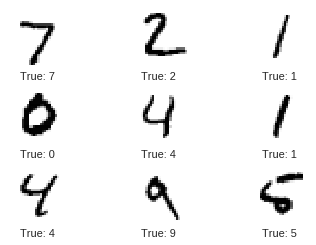

In [89]:

# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)




In [0]:


x=tf.placeholder(tf.float32,[None,img_size_flat])
# Placeholder allows us to change the images that are input to the tensorflow graph. These are tensors which are multidimensional matrix or vectors.
# Data type is float 32 and shape is [None,img_size_flat] where None means the tensors may hold arbitrary no of images where each image can be a vector of size img_size_flat.

y_true=tf.placeholder(tf.int64,[None,num_classes])
# Placeholder for true labels associated with the images that were input in the placeholder variable x.Shape is [None,num_classes]
# where it can handle arbitrary number of rows but each label is  a vector of length 10 

y_true_cls=tf.placeholder(tf.int64, [None])



weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))
# Note-nothing is initialized or calculate at this point of time. We just building the computational graph . Later we execute it

In [0]:
logits=tf.matmul(x,weights)+biases

# Now logits is a matrix with num_images rows and num_classes columns, where the element of the $i$'th row and $j$'th column is an estimate of how likely the
# $i$'th input image is to be of the $j$'th class.

# However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each row
# of the logits matrix sums to one, and each element is limited between zero and one. 
# This is calculated using the so-called softmax function and the result is stored in y_pred.

In [92]:
print(x.shape)
print(weights.shape)
print(biases.shape)
print(logits.shape)
print(28*28)

(?, 784)
(784, 10)
(10,)
(?, 10)
784


In [0]:
y_pred=tf.nn.softmax(logits)
y_pred_cls=tf.argmax(y_pred,axis=1)

In [0]:
# Loss function
cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=y_true)
# Cost-function to be optimized
# To make the model better at classifying the input images, we must somehow change the variables for weights and biases. To do this we first need to know how well
# the model currently performs by comparing the predicted output of the model y_pred to the desired output y_true.

# The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output 
# of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets 
# as close to zero as possible by changing the weights and biases of the model.

# TensorFlow has a built-in function for calculating the cross-entropy. Note that it uses the values of the logits because it also calculates the softmax
# internally

In [0]:
# Cost Function
cost=tf.reduce_mean(cross_entropy)
# We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually.
# But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, 
# so we simply take the average of the cross-entropy for all the image classifications.

In [0]:
# Optimization method
# Now that we have a cost measure that must be minimized, we can then create an optimizer. 
# In this case it is the basic form of Gradient Descent where the step-size is set to 0.5.
optimizer=tf.train.GradientDescentOptimizer(learning_rate=.5).minimize(cost)
# untill here we are building computation graph only and nothing is calculated.

In [0]:
# Checking performances
# This is a vector of booleans whether the predicted class equals the true class of each image.
correct_prediction=tf.equal(y_pred_cls,y_true_cls)
accuracy=tf.reduce_mean(tf.cast(correct_predicn,tf.float32))
# This calculates the classification accuracy by first
# type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

In [0]:
# TensorFlow Run
# Create TensorFlow session
# Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.
session=tf.Session()

In [0]:
# Initialize variables
session.run(tf.global_variables_initializer())

In [0]:
# Helper-function to perform optimization iterations
# There are 50.000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images.
# We therefore use Stochastic Gradient Descent which only uses a small batch of images in each iteration of the optimizer.
batch_size = 100

def optimize(num_iterations):
  for i in range(num_iterations):
            # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch,y_true_batch =data.train.next_batch(batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        
        feed_dict_train={x:x_batch,y_true:y_true_batch}
        
        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        
        session.run(optimizer,feed_dict=feed_dict_train)

In [0]:
# Here it goes behind the scenes and calculates the gradients for weights and biases and updates it

In [0]:
# Helper-functions to show performance
# Dict with the test-set data to be used as input to the TensorFlow graph. Note that we must use the correct names for the
# placeholder variables in the TensorFlow graph.

In [0]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

In [0]:
def print_accuracy():
  acc=session.run(accuracy, feed_dict=feed_dict_test)
  print("Accuracy on test-set: {0:.1%}".format(acc))

In [0]:
def print_confusion_matrix():
  cls_true=data.test.cls
  # Get the predicted classifications for the test-set.
  cls_pred=session.run(y_pred_cls, feed_dict=feed_dict_test)
  # Get the confusion matrix using sklearn.
  cm=confusion_matrix(y_true=cls_true,y_pred=cls_pred)
  print(cm)
  # Plot the confusion matrix as an image.
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

  # Make various adjustments to the plot.
  plt.tight_layout()
  plt.colorbar()
  tick_marks = np.arange(num_classes)
  plt.xticks(tick_marks, range(num_classes))
  plt.yticks(tick_marks, range(num_classes))
  plt.xlabel('Predicted')
  plt.ylabel('True')

  # Ensure the plot is shown correctly with multiple plots
  # in a single Notebook cell.
  plt.show()

In [0]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [0]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [0]:
# Performance before any optimization
# The accuracy on the test-set is 9.8%. This is because the model has only been initialized and not optimized at all, so it always predicts that the image shows a zero digit, 
# as demonstrated in the plot below, and it turns out that 9.8% of the images in the test-set happens to be zero digits.


In [108]:
print_accuracy()

Accuracy on test-set: 9.8%


9


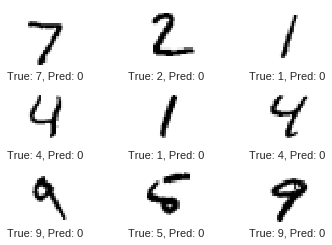

In [111]:
plot_example_errors()

In [0]:
optimize(num_iterations=1)

In [113]:
print_accuracy()

Accuracy on test-set: 32.5%


9


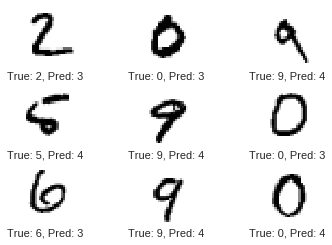

In [114]:
plot_example_errors()

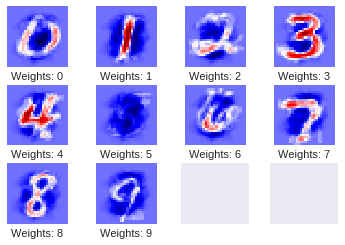

In [116]:
plot_weights()
# The 1 filter generally looks for red type pattern so if we pass 1 where there is black pixxel in center .. Then this filter around here will have positive reaction to the
# input image.

In [117]:
optimize(num_iterations=9)
print_accuracy()

Accuracy on test-set: 70.1%


9


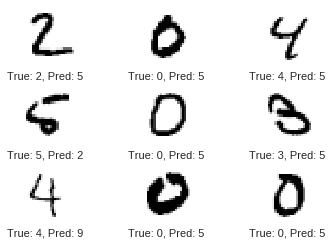

In [118]:
plot_example_errors()

In [119]:
optimize(num_iterations=990)
print_accuracy()

Accuracy on test-set: 92.0%


9


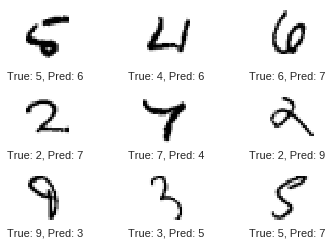

In [120]:
plot_example_errors()

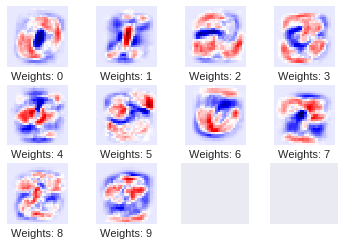

In [121]:
plot_weights()

[[ 966    0    2    2    0    3    4    1    2    0]
 [   0 1107    2    2    0    2    4    2   16    0]
 [  13   12  893   18   12    1   12   15   48    8]
 [   4    1   12  923    0   21    2   12   28    7]
 [   2    2    3    1  905    0   15    2   13   39]
 [  11    3    4   40    9  756   13    8   41    7]
 [  17    3    3    2    9   14  904    3    3    0]
 [   3    9   18    9    6    1    0  948    4   30]
 [   5    6    5   16    8   19   10   11  892    2]
 [  12    6    2   10   27    6    0   29   12  905]]


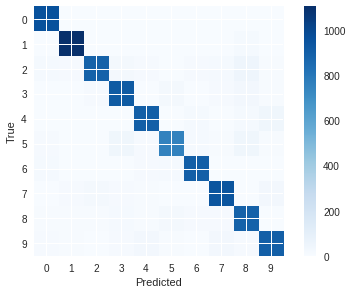

In [122]:
print_confusion_matrix()